In [ ]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install -q swig
!pip install -q gymnasium[box2d]

from pyvirtualdisplay import Display
Display().start()

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1

In [ ]:
env = gym.make("LunarLander-v2")

#**Знакомство со средой Lunar Lander**




1.   Выяснить тип простанств, изучить размерности
2.   Описать пространство состояний
3.   Описать пространство действий
4.   Описать функцию награды
5.   Провести эксперимент по построению траектории агентом в данной среде



1. Пространством являетя Box - ограниченное пространство, где мы можем определить верхний и нижний пределы, которые описывают допустимые значения, которые могут принимать наши наблюдения. Посадочная площадка всегда находится в координатах (0,0). Координаты - это первые два числа в векторе состояния. Возможна посадка за пределами посадочной площадки. Запас топлива бесконечен, поэтому агент может научиться летать, а затем приземлиться с первой попытки.
2. Состояние представляет собой 8-мерный вектор: координаты посадочного модуля в x и y, его линейные скорости в x и y, его угол, его угловая скорость и два логических значения, которые представляют, соприкасается ли каждая опора с землей или нет.
3. Доступны четыре отдельных действия: ничего не делать, запустить механизм ориентации влево, запустить основной двигатель, запустить механизм ориентации вправо.
4. Награда за перемещение от верхней части экрана к посадочной площадке и остановку составляет около 100-140 очков. Если посадочный модуль удаляется от посадочной площадки, он теряет награду. Если посадочный модуль падает, он получает дополнительные -100 очков. Если он останавливается, то получает дополнительные +100 очков. Каждая нога, соприкасающаяся с землей, составляет +10 очков. Включение основного двигателя составляет -0,3 балла за каждый кадр. Включение бокового двигателя составляет -0,03 балла за каждый кадр. Решено - 200 баллов.

In [ ]:
print(env.reset())
print(env.action_space)
print(env.observation_space)


[ 1.1861802e-03  1.4067354e+00  1.2013104e-01 -1.8599336e-01
 -1.3676818e-03 -2.7211497e-02  0.0000000e+00  0.0000000e+00]
Discrete(4)
Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)


 # Эксперимент по построению траектории агентом в данной среде

In [ ]:
import numpy as np
from IPython.display import clear_output
import time


state = env.reset()

for _ in range(1000):
  plt.imshow(env.render(mode = 'rgb_array'))
  display.clear_output(wait = True)
  display.display(plt.gcf())

  action = env.action_space.sample()
  next_state, reward, done, info = env.step(action)
  if done:
    env.reset()

  time.sleep(0.001)
env.close()
display.stop()


Корабль даже не пытается приземлиться

# **Реализация алгоритма решения задачи обучения с подкреплением в среде Lunar Lander**



1.   Описать алгоритм
2.   Реализовать алгоритм (используем pytorch)
3.   Проведение экспериментов и оценка качества полученного решения



Алгоритм reinforce используется для обновления политики на основе градиента ожидаемого общего вознаграждения. В отличие от других алгоритмов обучения с подкреплением, алгоритм reinforce не использует функции значений для оценки качества политики, а вместо этого напрямую оптимизирует политику.

# Реализация алгоритма

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class PolicyNetwork:
  def __init__(self, n_state, n_action, n_hidden = 50, lr = 0.0001):
    self.model = nn.Sequential(
        nn.Linear(n_state, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_action),
        nn.Softmax(),
    )
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

  def predict(self, s):
    return self.model(torch.Tensor(s))

  def update(self, returns, log_probs):
    policy_gradient = []
    for log_prob, Gt in zip(log_probs, returns):
      policy_gradient.append(-log_prob * Gt)

    loss = torch.stack(policy_gradient).sum()
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
  def get_action(self, s):
    probs = self.predict(s)
    action = torch.multinomial(probs, 1).item()
    log_prob = torch.log(probs[action])
    return action, log_prob

In [ ]:
def reinforce(env, estimator, n_episode, gamma = 1.0):
  for episode in range(n_episode):
    log_probs = []
    rewards = []
    state = env.reset()
    while True:
      action, log_prob = estimator.get_action(state)
      next_state, reward, is_done, _ = env.step(action)

      total_reward_episode[episode] += reward
      log_probs.append(log_prob)
      rewards.append(reward)

      if is_done:
        returns = []
        Gt = 0
        pw = 0
        for reward in rewards[::-1]:
          Gt += gamma ** pw * reward
          pw += 1
          returns.append(Gt)
        returns = returns[::-1]
        returns = torch.tensor(returns)
        returns = (returns - returns.mean())/(returns.std() + 1e-9)

        estimator.update(returns, log_probs)
        print(f'epis: {episode}, total_reward: {total_reward_episode[episode]}' )
        break

      state = next_state

In [ ]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 128
lr = 0.003
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)

In [ ]:
n_episode = 500
gamma = 0.9
total_reward_episode = [0] * n_episode

In [ ]:
reinforce(env, policy_net, n_episode, gamma)

epis: 0, total_reward: -58.15042268952301
epis: 1, total_reward: -333.36267332113925
epis: 2, total_reward: -183.244377914379
epis: 3, total_reward: -517.6394824523666
epis: 4, total_reward: -256.98526116882766
epis: 5, total_reward: -362.3140848315055
epis: 6, total_reward: -338.97260564075054
epis: 7, total_reward: -296.62322665977644
epis: 8, total_reward: -480.64474573213954
epis: 9, total_reward: -114.60738025242699
epis: 10, total_reward: -108.33321422536575
epis: 11, total_reward: -471.614437014978
epis: 12, total_reward: -431.5172785660651
epis: 13, total_reward: -174.28634653632918
epis: 14, total_reward: -108.34158744520258
epis: 15, total_reward: -151.1298318178841
epis: 16, total_reward: -190.76987942284686
epis: 17, total_reward: -169.24692126906325
epis: 18, total_reward: -211.48716706575215
epis: 19, total_reward: -137.21027529209493
epis: 20, total_reward: -386.73060604017894
epis: 21, total_reward: -184.46442894402983
epis: 22, total_reward: -169.54094391904718
epis: 2

# Проведение экспериментов и оценка качества полученного решения

KeyboardInterrupt: 

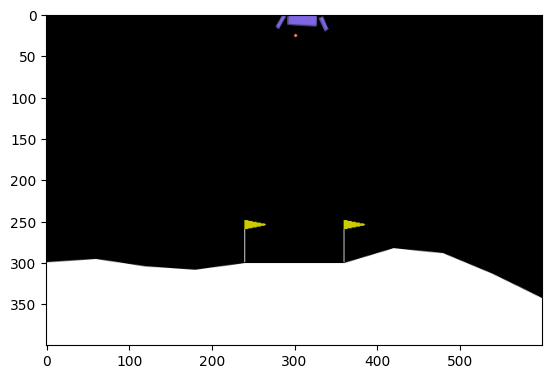

In [ ]:
import numpy as np
from IPython.display import clear_output
import time


state = env.reset()

for _ in range(1000):
  plt.imshow(env.render(mode = 'rgb_array'))
  display.clear_output(wait = True)
  display.display(plt.gcf())

  action = env.action_space.sample()
  next_state, reward, done, info = env.step(action)
  if done:
    env.reset()

  time.sleep(0.001)
env.close()
display.stop()


После обучения корабль стал приземляться более удачно

In [ ]:
print("mean reward:", sum(total_reward_episode)/n_episode)
print("max reward:", max(total_reward_episode))
print("min reward:", min(total_reward_episode))



mean reward: -178.34880781064462
max reward: 59.136176739870734
min reward: -612.1870761932041


#**Реализация алгоритма Актор-Критик**

In [ ]:
class ActorCriticModel(nn.Module):

  def __init__(self, n_input, n_output, n_hidden):

    super(ActorCriticModel, self).__init__()
    self.fc = nn.Linear(n_input, n_hidden)
    self.action = nn.Linear(n_hidden, n_output)
    self.value = nn.Linear(n_hidden, 1)

  def forward(self, x):

    x = torch.Tensor(x)
    x = F.relu(self.fc(x))
    action_probs = F.softmax(self.action(x), dim=-1)
    state_value = self.value(x)
    return action_probs, state_value



In [ ]:
class PolicyNetwork():

  def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):

    self. model = ActorCriticModel(n_state, n_action, n_hidden)
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
    self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.9)

  def predict(self, s):

    return self. model(torch.Tensor(s))

  def update(self, returns, log_probs, state_values):

    loss = 0
    for log_prob, value, Gt in zip(log_probs, state_values, returns):

      advantage = Gt - value.item()
      policy_loss = -log_prob * advantage
      value_loss = F.smooth_l1_loss(value, Gt)
      loss += policy_loss + value_loss

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def get_action(self, s):

    action_probs, state_value = self.predict(s)
    action = torch.multinomial(action_probs, 1).item()
    log_prob = torch.log(action_probs[action])
    return action, log_prob, state_value

  def get_state_value(self, s):

    _, state_value = self.predict(s)
    return state_value

In [ ]:
def actor_critic(env, estimator, n_episode, gamma=1.0):

  for episode in range(n_episode):
    log_probs=[]
    rewards = []
    state_values = []

    state = env.reset()
    while True:
      action, log_prob, state_value = estimator.get_action(state)
      next_state, reward, is_done, _ = env.step(action)
      total_reward_episode[episode] += reward
      log_probs.append(log_prob)
      rewards.append(reward)
      state_values.append(state_value)

      if is_done:
        returns = []
        Gt = 0
        pw = 0
        for reward in rewards[::-1]:
          Gt += gamma ** pw * reward
          pw += 1
          returns.append(Gt)

        returns = returns[::-1]
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        estimator.update(returns, log_probs, state_values)
        if total_reward_episode[episode] >= 195:
          estimator.scheduler.step()
        break

      state = next_state

##**Реализация для среды CartPole-vo (по полным траекториям)**

In [ ]:
env = gym.envs.make('CartPole-v0')

In [ ]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 128
lr = 0.03
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)

In [ ]:
n_episode = 1000
gamma = 0.9
total_reward_episode = [0] * n_episode

In [ ]:
actor_critic(env, policy_net, n_episode, gamma)

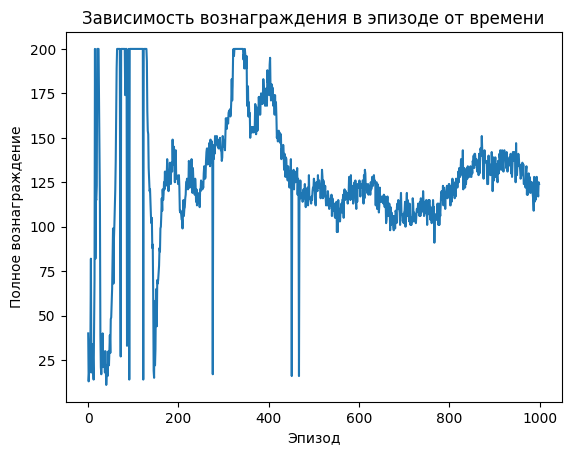

In [ ]:
plt.plot(total_reward_episode)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()

## **Реализация для среды CartPole-v0 с одношаговым бутстрэппингом**

In [ ]:
def actor_critic(env, estimator, n_episode, gamma=1.0):

  for episode in range(n_episode):
    log_probs=[]
    rewards = []
    state_values = []

    state = env.reset()
    while True:
      action, log_prob, state_value = estimator.get_action(state)
      next_state, reward, is_done, _ = env.step(action)
      total_reward_episode[episode] += reward
      log_probs.append(log_prob)
      rewards.append(reward)
      state_values.append(state_value)

      if is_done:
        next_state_value = estimator.get_state_value(next_state)
        returns = []

        Gt = reward + gamma * next_state_value

        returns.append(Gt)

        returns = torch.tensor(returns)
        returns = (torch.tensor(returns) - torch.tensor(next_state_value))

        estimator.update(returns, log_probs, state_values)
        if total_reward_episode[episode] >= 195:
          estimator.scheduler.step()
        break

      state = next_state

In [ ]:
env = gym.envs.make('CartPole-v0')
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 128
lr = 0.03
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)
n_episode = 1000
gamma = 0.9
total_reward_episode = [0] * n_episode

In [ ]:
actor_critic(env, policy_net, n_episode, gamma)

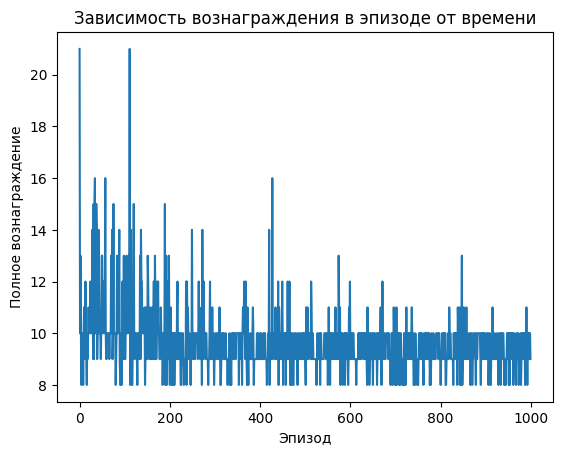

In [ ]:
plt.plot(total_reward_episode)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()

## **Реализация для среды Lunar Lander (по полным траекториям**)

## **Реализация для среды Lunar Lander c одношаговым бутстрэппингом**

# Тесты

Вопросы Зайцев:


В чем отличие контекстуальных бандитов от многоруких?
1. добавляется состояние*
2. нет агента
3. контекстуальные бандиты используют меньше данных
4. многорукие бандиты используют контекст для принятия решений

Из каких объектов может быть представлена задача RL?
1. оценщик
2. агент*
3. модель
4. среда*

Вопросы Пикалов:


с какой вероятностью выбирается действие в epsilon-жадной стратегии?
1. 1-eps + eps/A     *
2. eps/A
3. 1/eps
4. A-eps




Две основные категории управления методом Монте-Карло:
1. Методы с единой стратегией (on-policy)       *
2. Методы с разделенной стратегией (off-policy) *
3. Методы целевой стратегии (target policy)
4. Методы поведенческой стратегии (behaviour policy)

# Алгоритм PPO

In [ ]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

In [ ]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

In [ ]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='sample_data'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'sample_data')
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)

        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [ ]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='sample_data'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'sample_data')
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [ ]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)

    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

... saving models ...
episode 0 score 10.0 avg score 10.0 time_steps 10 learning_steps 0
... saving models ...
episode 1 score 11.0 avg score 10.5 time_steps 21 learning_steps 1
... saving models ...
episode 2 score 17.0 avg score 12.7 time_steps 38 learning_steps 1
... saving models ...
episode 3 score 17.0 avg score 13.8 time_steps 55 learning_steps 2
... saving models ...
episode 4 score 21.0 avg score 15.2 time_steps 76 learning_steps 3
... saving models ...
episode 5 score 24.0 avg score 16.7 time_steps 100 learning_steps 5
episode 6 score 10.0 avg score 15.7 time_steps 110 learning_steps 5
episode 7 score 14.0 avg score 15.5 time_steps 124 learning_steps 6
episode 8 score 12.0 avg score 15.1 time_steps 136 learning_steps 6
episode 9 score 10.0 avg score 14.6 time_steps 146 learning_steps 7
episode 10 score 9.0 avg score 14.1 time_steps 155 learning_steps 7
episode 11 score 11.0 avg score 13.8 time_steps 166 learning_steps 8
episode 12 score 8.0 avg score 13.4 time_steps 174 learn

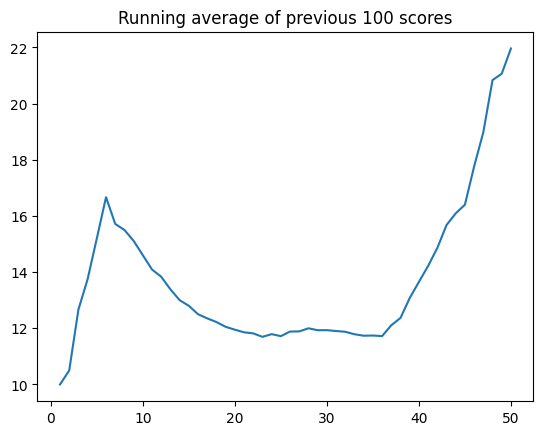

In [ ]:
import gym
import numpy as np

if __name__ == '__main__':
    env = gym.make('CartPole-v1')
    N = 20
    batch_size = 5
    n_epochs = 4
    alpha = 0.0003
    agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,
                    alpha=alpha, n_epochs=n_epochs,
                    input_dims=env.observation_space.shape)
    n_games = 50

    figure_file = '/content/cartpole.png'

    best_score = env.reward_range[0]
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0

    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            score += reward
            agent.remember(observation, action, prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
                learn_iters += 1
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()

        print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
                'time_steps', n_steps, 'learning_steps', learn_iters)
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file)

# Алгоритм DDPG

In [ ]:
!pip install ddpg_torch

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ERROR: Could not find a version that satisfies the requirement ddpg_torch (from versions: none)
ERROR: No matching distribution found for ddpg_torch


In [ ]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class OUActionNoise(object):
    def __init__(self, mu, sigma=0.15, theta=.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(
                                                            self.mu, self.sigma)

class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='sample_data/ddpg'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg')
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        #self.fc1.weight.data.uniform_(-f1, f1)
        #self.fc1.bias.data.uniform_(-f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        #f2 = 0.002
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        #self.fc2.weight.data.uniform_(-f2, f2)
        #self.fc2.bias.data.uniform_(-f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)
        f3 = 0.003
        self.q = nn.Linear(self.fc2_dims, 1)
        T.nn.init.uniform_(self.q.weight.data, -f3, f3)
        T.nn.init.uniform_(self.q.bias.data, -f3, f3)
        #self.q.weight.data.uniform_(-f3, f3)
        #self.q.bias.data.uniform_(-f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)

        action_value = F.relu(self.action_value(action))
        state_action_value = F.relu(T.add(state_value, action_value))
        state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='sample_data/ddpg'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg')
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        #self.fc1.weight.data.uniform_(-f1, f1)
        #self.fc1.bias.data.uniform_(-f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        #f2 = 0.002
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        #self.fc2.weight.data.uniform_(-f2, f2)
        #self.fc2.bias.data.uniform_(-f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        #f3 = 0.004
        f3 = 0.003
        self.mu = nn.Linear(self.fc2_dims, self.n_actions)
        T.nn.init.uniform_(self.mu.weight.data, -f3, f3)
        T.nn.init.uniform_(self.mu.bias.data, -f3, f3)
        #self.mu.weight.data.uniform_(-f3, f3)
        #self.mu.bias.data.uniform_(-f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = T.tanh(self.mu(x))

        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

class Agent(object):
    def __init__(self, alpha, beta, input_dims, tau, env, gamma=0.99,
                 n_actions=2, max_size=1000000, layer1_size=400,
                 layer2_size=300, batch_size=64):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size

        self.actor = ActorNetwork(alpha, input_dims, layer1_size,
                                  layer2_size, n_actions=n_actions,
                                  name='Actor')
        self.critic = CriticNetwork(beta, input_dims, layer1_size,
                                    layer2_size, n_actions=n_actions,
                                    name='Critic')

        self.target_actor = ActorNetwork(alpha, input_dims, layer1_size,
                                         layer2_size, n_actions=n_actions,
                                         name='TargetActor')
        self.target_critic = CriticNetwork(beta, input_dims, layer1_size,
                                           layer2_size, n_actions=n_actions,
                                           name='TargetCritic')

        self.noise = OUActionNoise(mu=np.zeros(n_actions))

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        self.actor.eval()
        observation = T.tensor(observation, dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(observation).to(self.actor.device)
        mu_prime = mu + T.tensor(self.noise(),
                                 dtype=T.float).to(self.actor.device)
        self.actor.train()
        return mu_prime.cpu().detach().numpy()


    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        state, action, reward, new_state, done = \
                                      self.memory.sample_buffer(self.batch_size)

        reward = T.tensor(reward, dtype=T.float).to(self.critic.device)
        done = T.tensor(done).to(self.critic.device)
        new_state = T.tensor(new_state, dtype=T.float).to(self.critic.device)
        action = T.tensor(action, dtype=T.float).to(self.critic.device)
        state = T.tensor(state, dtype=T.float).to(self.critic.device)

        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()
        target_actions = self.target_actor.forward(new_state)
        critic_value_ = self.target_critic.forward(new_state, target_actions)
        critic_value = self.critic.forward(state, action)

        target = []
        for j in range(self.batch_size):
            target.append(reward[j] + self.gamma*critic_value_[j]*done[j])
        target = T.tensor(target).to(self.critic.device)
        target = target.view(self.batch_size, 1)

        self.critic.train()
        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.critic.eval()
        self.actor.optimizer.zero_grad()
        mu = self.actor.forward(state)
        self.actor.train()
        actor_loss = -self.critic.forward(state, mu)
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_dict = dict(target_critic_params)
        target_actor_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                      (1-tau)*target_critic_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                      (1-tau)*target_actor_dict[name].clone()
        self.target_actor.load_state_dict(actor_state_dict)

        """
        #Verify that the copy assignment worked correctly
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(target_critic_params)
        actor_state_dict = dict(target_actor_params)
        print('\nActor Networks', tau)
        for name, param in self.actor.named_parameters():
            print(name, T.equal(param, actor_state_dict[name]))
        print('\nCritic Networks', tau)
        for name, param in self.critic.named_parameters():
            print(name, T.equal(param, critic_state_dict[name]))
        input()
        """
    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

    def check_actor_params(self):
        current_actor_params = self.actor.named_parameters()
        current_actor_dict = dict(current_actor_params)
        original_actor_dict = dict(self.original_actor.named_parameters())
        original_critic_dict = dict(self.original_critic.named_parameters())
        current_critic_params = self.critic.named_parameters()
        current_critic_dict = dict(current_critic_params)
        print('Checking Actor parameters')

        for param in current_actor_dict:
            print(param, T.equal(original_actor_dict[param], current_actor_dict[param]))
        print('Checking critic parameters')
        for param in current_critic_dict:
            print(param, T.equal(original_critic_dict[param], current_critic_dict[param]))
        input()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plotLearning(scores, filename, x=None, window=5):
    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-window):(t+1)])
    if x is None:
        x = [i for i in range(N)]
    plt.ylabel('Score')
    plt.xlabel('Game')
    plt.plot(x, running_avg)
    plt.savefig(filename)

episode  0 score -368.83 trailing 100 games avg -368.833
episode  1 score -142.25 trailing 100 games avg -255.543
episode  2 score -131.29 trailing 100 games avg -214.127
episode  3 score -145.86 trailing 100 games avg -197.060
episode  4 score -124.45 trailing 100 games avg -182.538
episode  5 score -110.29 trailing 100 games avg -170.497
episode  6 score -148.01 trailing 100 games avg -167.285
episode  7 score -251.32 trailing 100 games avg -177.789
episode  8 score -273.47 trailing 100 games avg -188.421
episode  9 score -348.19 trailing 100 games avg -204.397
episode  10 score -317.65 trailing 100 games avg -214.693
episode  11 score -523.01 trailing 100 games avg -240.386
episode  12 score -407.33 trailing 100 games avg -253.228
episode  13 score -333.93 trailing 100 games avg -258.993
episode  14 score -293.24 trailing 100 games avg -261.276
episode  15 score -244.00 trailing 100 games avg -260.197
episode  16 score -312.61 trailing 100 games avg -263.280
episode  17 score -392.2

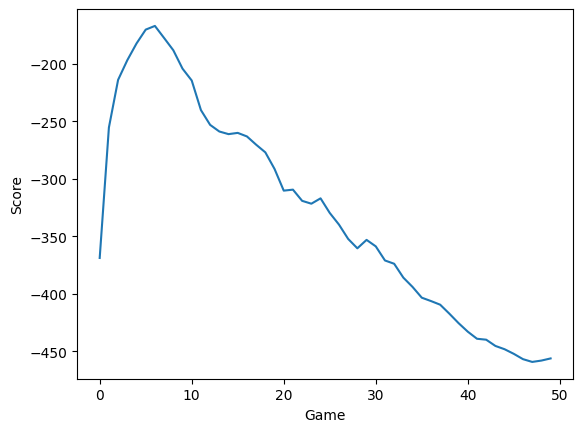

In [ ]:
import gym
import numpy as np

env = gym.make('LunarLanderContinuous-v2')
agent = Agent(alpha=0.000025, beta=0.00025, input_dims=[8], tau=0.001, env=env,
              batch_size=64,  layer1_size=400, layer2_size=300, n_actions=2)

#agent.load_models()
np.random.seed(0)

score_history = []
for i in range(50):
    obs = env.reset()
    done = False
    score = 0
    while not done:
        act = agent.choose_action(obs)
        new_state, reward, done, info = env.step(act)
        agent.remember(obs, act, reward, new_state, int(done))
        agent.learn()
        score += reward
        obs = new_state
        #env.render()
    score_history.append(score)

    #if i % 25 == 0:
    #    agent.save_models()

    print('episode ', i, 'score %.2f' % score,
          'trailing 100 games avg %.3f' % np.mean(score_history[-100:]))

filename = 'LunarLander-alpha000025-beta00025-400-300.png'
plotLearning(score_history, filename, window=100)

# Алгоритм TD3

In [ ]:
import numpy as np
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os

class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done
        self.reward_memory[index] = reward
        self.action_memory[index] = action

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones


class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions,
            name, chkpt_dir='sample_data/td3'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_td3')

        self.fc1 = nn.Linear(self.input_dims[0] + n_actions, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.q1 = nn.Linear(self.fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state, action):
        q1_action_value = self.fc1(T.cat([state, action], dim=1))
        q1_action_value = F.relu(q1_action_value)
        q1_action_value = self.fc2(q1_action_value)
        q1_action_value = F.relu(q1_action_value)

        q1 = self.q1(q1_action_value)

        return q1

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims,
            n_actions, name, chkpt_dir='sample_data/td3'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_td3')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.mu = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state):
        prob = self.fc1(state)
        prob = F.relu(prob)
        prob = self.fc2(prob)
        prob = F.relu(prob)

        mu = T.tanh(self.mu(prob))

        return mu

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))


class Agent():
    def __init__(self, alpha, beta, input_dims, tau, env,
            gamma=0.99, update_actor_interval=2, warmup=1000,
            n_actions=2, max_size=1000000, layer1_size=400,
            layer2_size=300, batch_size=100, noise=0.1):
        self.gamma = gamma
        self.tau = tau
        self.max_action = env.action_space.high
        self.min_action = env.action_space.low
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.learn_step_cntr = 0
        self.time_step = 0
        self.warmup = warmup
        self.n_actions = n_actions
        self.update_actor_iter = update_actor_interval

        self.actor = ActorNetwork(alpha, input_dims, layer1_size,
                        layer2_size, n_actions=n_actions, name='actor')

        self.critic_1 = CriticNetwork(beta, input_dims, layer1_size,
                        layer2_size, n_actions=n_actions, name='critic_1')
        self.critic_2 = CriticNetwork(beta, input_dims, layer1_size,
                        layer2_size, n_actions=n_actions, name='critic_2')

        self.target_actor = ActorNetwork(alpha, input_dims, layer1_size,
                    layer2_size, n_actions=n_actions, name='target_actor')
        self.target_critic_1 = CriticNetwork(beta, input_dims, layer1_size,
                layer2_size, n_actions=n_actions, name='target_critic_1')
        self.target_critic_2 = CriticNetwork(beta, input_dims, layer1_size,
                layer2_size, n_actions=n_actions, name='target_critic_2')

        self.noise = noise
        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        if self.time_step < self.warmup:
            mu = T.tensor(np.random.normal(scale=self.noise,
                                            size=(self.n_actions,)))
        else:
            state = T.tensor(observation, dtype=T.float).to(self.actor.device)
            mu = self.actor.forward(state).to(self.actor.device)
        mu_prime = mu + T.tensor(np.random.normal(scale=self.noise),
                                    dtype=T.float).to(self.actor.device)

        mu_prime = T.clamp(mu_prime, self.min_action[0], self.max_action[0])
        self.time_step += 1

        return mu_prime.cpu().detach().numpy()

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        state, action, reward, new_state, done = \
                self.memory.sample_buffer(self.batch_size)

        reward = T.tensor(reward, dtype=T.float).to(self.critic_1.device)
        done = T.tensor(done).to(self.critic_1.device)
        state_ = T.tensor(new_state, dtype=T.float).to(self.critic_1.device)
        state = T.tensor(state, dtype=T.float).to(self.critic_1.device)
        action = T.tensor(action, dtype=T.float).to(self.critic_1.device)

        target_actions = self.target_actor.forward(state_)
        target_actions = target_actions + \
                T.clamp(T.tensor(np.random.normal(scale=0.2)), -0.5, 0.5)
        target_actions = T.clamp(target_actions, self.min_action[0],
                                self.max_action[0])

        q1_ = self.target_critic_1.forward(state_, target_actions)
        q2_ = self.target_critic_2.forward(state_, target_actions)

        q1 = self.critic_1.forward(state, action)
        q2 = self.critic_2.forward(state, action)

        q1_[done] = 0.0
        q2_[done] = 0.0

        q1_ = q1_.view(-1)
        q2_ = q2_.view(-1)

        critic_value_ = T.min(q1_, q2_)

        target = reward + self.gamma*critic_value_
        target = target.view(self.batch_size, 1)

        self.critic_1.optimizer.zero_grad()
        self.critic_2.optimizer.zero_grad()

        q1_loss = F.mse_loss(target, q1)
        q2_loss = F.mse_loss(target, q2)
        critic_loss = q1_loss + q2_loss
        critic_loss.backward()
        self.critic_1.optimizer.step()
        self.critic_2.optimizer.step()

        self.learn_step_cntr += 1

        if self.learn_step_cntr % self.update_actor_iter != 0:
            return

        self.actor.optimizer.zero_grad()
        actor_q1_loss = self.critic_1.forward(state, self.actor.forward(state))
        actor_loss = -T.mean(actor_q1_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_1_params = self.critic_1.named_parameters()
        critic_2_params = self.critic_2.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_1_params = self.target_critic_1.named_parameters()
        target_critic_2_params = self.target_critic_2.named_parameters()

        critic_1 = dict(critic_1_params)
        critic_2 = dict(critic_2_params)
        actor = dict(actor_params)
        target_actor = dict(target_actor_params)
        target_critic_1 = dict(target_critic_1_params)
        target_critic_2 = dict(target_critic_2_params)

        for name in critic_1:
            critic_1[name] = tau*critic_1[name].clone() + \
                    (1-tau)*target_critic_1[name].clone()

        for name in critic_2:
            critic_2[name] = tau*critic_2[name].clone() + \
                    (1-tau)*target_critic_2[name].clone()

        for name in actor:
            actor[name] = tau*actor[name].clone() + \
                    (1-tau)*target_actor[name].clone()

        self.target_critic_1.load_state_dict(critic_1)
        self.target_critic_2.load_state_dict(critic_2)
        self.target_actor.load_state_dict(actor)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.target_critic_1.save_checkpoint()
        self.target_critic_2.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic_1.load_checkpoint()
        self.critic_2.load_checkpoint()
        self.target_critic_1.load_checkpoint()
        self.target_critic_2.load_checkpoint()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

In [ ]:
import gym
import numpy as np

if __name__ == '__main__':
    env = gym.make('LunarLanderContinuous-v2')
    agent = Agent(alpha=0.001, beta=0.001,
            input_dims=env.observation_space.shape, tau=0.005,
            env=env, batch_size=100, layer1_size=400, layer2_size=300,
            n_actions=env.action_space.shape[0])
    n_games = 1000
    filename = 'plots/' + 'LunarLanderContinuous_' + str(n_games) + '_games.png'

    best_score = env.reward_range[0]
    score_history = []

    agent.load_models()

    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            agent.remember(observation, action, reward, observation_, done)
            agent.learn()
            score += reward
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()

        print('episode ', i, 'score %.1f' % score,
                'average score %.1f' % avg_score)

    x = [i+1 for i in range(n_games)]
    plot_learning_curve(x, score_history, filename)

... loading checkpoint ...


FileNotFoundError: [Errno 2] No such file or directory: 'sample_data/td3/actor_td3'

# **Оптимизация**

[Моделирование размещения хабов в pyomo](https://habr.com/ru/articles/772012/)

## О задаче

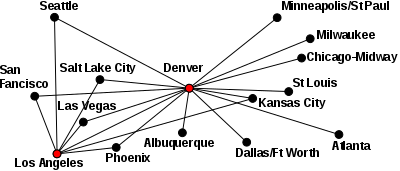

Задача размещения хабов состоит в размещении хабов и построении сети хабов (построение соединений/ребер сети) с целью оптимизации затрат/уровня сервиса.  
Хабом называется объект сети, который обеспечивает распределение, соединение, переключение, консолидацию, сортировку или перевалку в распределенных системах много-ко-многим.

Выделяют следующие преимущества использования сетей с хабами:

- Экономия на масштабе (экономика масштаба). Консолидация трафика на хабах позволяет сформировать большие потоки между хабами, что приводит к меньшим издержкам на трансфер (например, более плотное заполнение транспорта в перевозке сборных грузов);

- Сокращение затрат на установку соединений между "непопулярными" или труднодоступными направлениями;

- Повышение уровня сервиса за счет более регулярных отправок;

- Сокращение затрат на управление сетью.

Задача является актуальной в транспортных, компьютерных и телекоммуникационных сетях. В частности, авиа перевозки пассажиров или грузов, почтовые отправки, перевозки сборных грузов, службы экстренного реагирования, сети маркетплэйсов и другие.

## Математическая модель
Так как проведение реальных экспериментов на реальных объектов безумно дорого, то используются различные модели, позволяющие оценить перспективы того или иного решения

Рассмотрим две наиболее популярных модели:
- Четырехиндексная (Campbell 1994, Skorin-Kapov et al., 1996)
- Трехиндексная (Ernst and Krishnamoorthy 1996)

Эти модели отличаются отличаются решающими переменными

#### Общая часть

Индексы

N = {1, .., n} - множество узлов  
K - подмножество узлов в N, которое может быть выбрано в качестве хаба

Константы

$w_{ij}$- поток из узла i в узел j;

$f_i$ - установка хаба в узле i;

$d_{ij}$ - расстояние между узлами i и j;

$\chi$ - стоимость консолидации потоков за единицу расстояния и единицу потока;

$\alpha$ - стоимость трансфера потоков за единицу расстояния и единицу потока (между хабами);

$\delta$ - стоимость распределения потоков за единицу расстояния и единицу потока;

$O_i = \sum_{j \in N} w_{ij}$ - общий исток из узла i;

$D_i = \sum_{j \in N} w_{ji}$ - общий сток в узел i;

$F_{ijkl} = w_{ij} (\chi d_{ik} + \alpha d_{kl} + \delta d_{lj})$ - затраты на транспортировку потока по маршруту из i в j через хабы k и l;

Размещение хабов в сети является целесообразным, когда $\alpha < \chi$ и $\alpha < \delta$. Здесь $\alpha$ моделирует эффект масштаба.

Иными словами, размещение хаба целесообразно, если переправка потоков между ними будет дешевле, чем напрямую из узла в узел

Переменные

$z_{kk}$ - бинарная переменная, принимает значение 1, если k выбран в качестве хаба;

$z_{ik}$ - бинарная переменная, привязка узла i сети к хабу k;

Ограничения

Каждый узел сети связан только с одним хабом:

$\sum_{k \in K} z_{ik} = 1$, $\quad \forall i \in N$

Связь узловой точки с хабом возможна, только если узловая точка выбрана в качестве хаба:

$z_{ik} \le z_{kk}, \quad \forall i \in N, k \in K$

### Модель 4-индекса

Переменные

$x_{ijkl}$ -вещественная переменная, доля всего потока из i в j, проходящая через хабы k и l;

Ограничения
- Весь поток из узла i в j должен проходить только через выбранный хаб (первый в маршруте):

$\sum_{l \in K} x_{ijkl} = z_{ik}, \quad \forall i, j \in N, k \in K$  


- Весь поток в узел j из i должен проходить только через связанный с этим узлом хаб (второй в маршруте):

$\sum_{k \in K} x_{ijkl} = z_{jl}, \quad \forall i, j \in N, l \in K$

- Общие ограничения (1) и (2)

Целевая функция  
Минимизация затрат на установку хаба и транспортные затраты:

$\min \sum_k f_{k} z_{kk} + \sum_{i, j \in N} \sum_{k,l \in K} F_{ijkl}x_{ijkl}$

### Модель 3-индекса

Переменные
$y_{ikl}$ - вещественная переменная, поток из узла i через хабы k и l;

Ограничения
- Балансирование потоков (flow conservation constraint). Рассмотрим входящие и исходящие потоки хаба k. Входящие потоки $O_ix_{ik}$ и $\sum_{l \in K} y_{ilk}$, поток от отправителя напрямую и поток из первого хаба соответственно. Исходящие потоки $\sum_{j \in N} w_{ij}x_{jk} и \sum_{l \in K} y_{ikl}$, поток напрямую к получателю и поток на второй хаб соответственно. Если свести баланс потоков в уравнение, то получим следующий баланс потоков в сети:

$O_ix_{ik} + \sum_{l \in K} y_{ilk} = \sum_{j \in N} w_{ij}x_{jk} + \sum_{l \in K} y_{ikl}, \quad \forall i \in N, k \in K$

- Общие ограничения (1) и (2)

Целевая функция


- Минимизация затрат на установку хаба и транспортные затраты:

$\min \sum_k f_{k} z_{kk} + \sum_{i \in N, k \in K} (\chi O_i + \delta D_i)d_{ik}z_{ik} + \sum_{k,l \in K} \alpha d_{kl}y_{ikl}$

## Данные

Задачу размещения хабов можно решать методами линейного программирования, квадратичного программирования, эвристическими (например, GRASP) или мета-эвристическими методами. Оценку производительности и проведение сравнительного анализа подходов к решению между собой необходимо проводить на фиксированном наборе данных (тестовый набор). Кроме того, новые концепции задачи также сравнивают с существующими, а теоретические выкладки подтверждают практическими экспериментами на этих данных. В научной среде в этих целях часто используются следующие наборы:  

- CAB (Civil Aeronautic Board). Данные совета гражданской авиации США: пассажиропоток авиакомпаний между 25 городами США, 1970 год.  

- AP (Australia Post). Почтовые отправки между 200 почтовых округов в Сиднее, Австралия.

- TR (Turkish Network). Потоки между 81 городом Турции; сформированы на основе численности населения.  

## Эффект масштаба

Одним из предположений классической постановки задачи размещения хабов является постоянная скидка на трансфер потоков между хабами. Это сильное предположение, которое не сочетается с реальностью. Одним из направлений в этой области является уход от классической постановки учета скидки (постоянный дисконт) к другим моделям:

- Нелинейная функция или кусочно-линейная функция скидки;

- Использование пороговых значений (кусочно-постоянная функция);

- Учет в модели дискретных единиц транспорта;

- Разложение функции затрат на постоянную и переменную часть.